In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 4393 (delta 1456), reused 1401 (delta 1401), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 28.21 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
data=download_data(source="https://github.com/davidosoriot/MachineLearning_projects/raw/main/cars.zip",
                                     destination="cars")
data

[INFO] Did not find data/cars directory, creating one...
[INFO] Downloading cars.zip from https://github.com/davidosoriot/MachineLearning_projects/raw/main/cars.zip...
[INFO] Unzipping cars.zip data...


PosixPath('data/cars')

In [5]:
# Setup directory paths to train and test images
train_dir = data / "trainc"
test_dir = data / "testc"

In [6]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 129MB/s]


In [7]:
 #5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same
              out_features=3)) # change out_features to suit our number of classes

In [8]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [9]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [10]:
from torchinfo import summary

In [11]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                  test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)


In [12]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1285 | train_acc: 0.3094 | test_loss: 1.0720 | test_acc: 0.4889
Epoch: 2 | train_loss: 0.9906 | train_acc: 0.5659 | test_loss: 1.0304 | test_acc: 0.4884
Epoch: 3 | train_loss: 0.9181 | train_acc: 0.6994 | test_loss: 0.9809 | test_acc: 0.5524
Epoch: 4 | train_loss: 0.8743 | train_acc: 0.7082 | test_loss: 0.9634 | test_acc: 0.5524
Epoch: 5 | train_loss: 0.7993 | train_acc: 0.7884 | test_loss: 0.9425 | test_acc: 0.5842
Epoch: 6 | train_loss: 0.7790 | train_acc: 0.8051 | test_loss: 0.9184 | test_acc: 0.5524
Epoch: 7 | train_loss: 0.7102 | train_acc: 0.8208 | test_loss: 0.9022 | test_acc: 0.5847
Epoch: 8 | train_loss: 0.6763 | train_acc: 0.8369 | test_loss: 0.8867 | test_acc: 0.5852
Epoch: 9 | train_loss: 0.6448 | train_acc: 0.8468 | test_loss: 0.8826 | test_acc: 0.5691
Epoch: 10 | train_loss: 0.6153 | train_acc: 0.8646 | test_loss: 0.8770 | test_acc: 0.5852


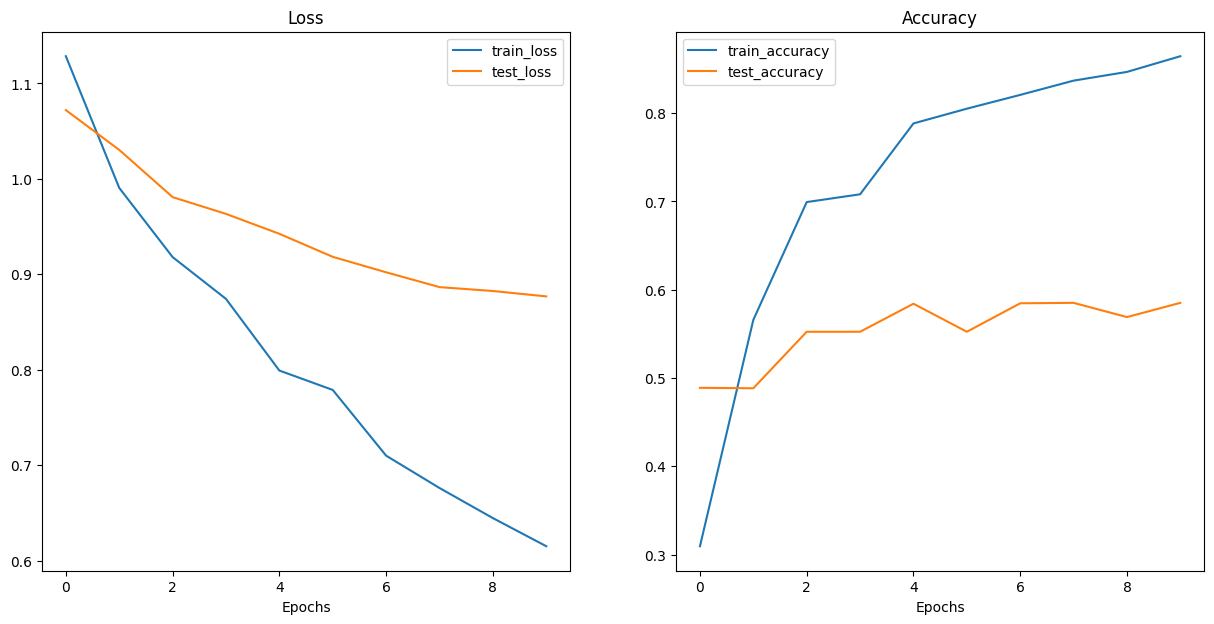

In [13]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [14]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="effnetb2_cars.pth")


[INFO] Saving model to: models/effnetb2_cars.pth


In [15]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/effnetb2_cars.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [16]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [22]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/cars/testc


[PosixPath('data/cars/testc/porsche/tp4.jpg'),
 PosixPath('data/cars/testc/porsche/tp2.jpg'),
 PosixPath('data/cars/testc/porsche/tp19.jpg'),
 PosixPath('data/cars/testc/porsche/tp9.jpg'),
 PosixPath('data/cars/testc/porsche/tp5.jpg')]

In [17]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats


{'test_loss': 0.8769659996032715,
 'test_acc': 0.5851814516129032,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [18]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaries
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

In [23]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/60 [00:00<?, ?it/s]

In [24]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/cars/testc/porsche/tp4.jpg,porsche,0.6830,bmw,0.3042,False
1,data/cars/testc/porsche/tp2.jpg,porsche,0.3752,porsche,0.2424,True
2,data/cars/testc/porsche/tp19.jpg,porsche,0.6841,bmw,0.2354,False
3,data/cars/testc/porsche/tp9.jpg,porsche,0.5223,porsche,0.2232,True
4,data/cars/testc/porsche/tp5.jpg,porsche,0.4048,porsche,0.1967,True


In [25]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.1542 seconds


In [26]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00
Gradio version: 5.17.0


In [27]:
# Put EffNetB2 on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [28]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [29]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/cars/testc/ferrari/tf20.jpg

Prediction label and probability dictionary: 
{'bmw': 0.06496281176805496, 'ferrari': 0.7567278742790222, 'porsche': 0.17830923199653625}
Prediction time: 0.43932 seconds


In [30]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/cars/testc/porsche/tp22.jpg'],
 ['data/cars/testc/ferrari/tf17.jpg'],
 ['data/cars/testc/porsche/tp3.jpg']]

In [35]:
import gradio as gr

# Create title, description and article strings
title = "BMW, FERRARI OR PORSCHE?"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of bmw, ferrari or porsche."
article=""

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f36663ac972551d8af.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
